In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 256) 
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [57]:
#torch.manual_seed(7)

In [58]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_61136/112231088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_61136/112231088.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [59]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_61136/3473755828.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_61136/3473755828.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [60]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    inl.weight.data = ninc
    oul.weight.data = noul


In [61]:
model = model
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

acc = []

l2_lambda = 0.0005

num_epochs = 100  
for epoch in range(num_epochs):
    ttot = 0
    tcorr = 0
    for b in tqdm(trainloader):
        xt, y = b[0], b[1]
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 

        l2_penalty = sum(torch.sum(p**2) for p in model.parameters())
        loss += l2_lambda * l2_penalty 
        
        loss.backward() 
        optimizer.step() 
    
        _, y = torch.max(y.data, 1)
        _, pred = torch.max(outputs.data, 1)
        ttot += y.shape[0]
        tcorr += (pred == y).sum().item()
    
    # for i in range(len(lay)):
    #     if i > 0 and i <= len(lay)-1:
    #         di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, train dataset accuracy: {100*tcorr/ttot}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0], i[1]
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')
    acc.append(corr/tot)


Linear
Linear
Linear
Linear
Linear


100%|██████████| 235/235 [00:01<00:00, 143.88it/s]


Epoch 0/100, Loss: 0.054941803216934204, train dataset accuracy: 67.12
test dataset accuracy: 89.45%


100%|██████████| 235/235 [00:01<00:00, 148.02it/s]


Epoch 1/100, Loss: 0.04545065015554428, train dataset accuracy: 90.45
test dataset accuracy: 89.62%


100%|██████████| 235/235 [00:01<00:00, 142.63it/s]


Epoch 2/100, Loss: 0.0405549630522728, train dataset accuracy: 90.99333333333334
test dataset accuracy: 90.6%


100%|██████████| 235/235 [00:01<00:00, 147.01it/s]


Epoch 3/100, Loss: 0.0453205406665802, train dataset accuracy: 91.60833333333333
test dataset accuracy: 91.88%


100%|██████████| 235/235 [00:01<00:00, 141.85it/s]


Epoch 4/100, Loss: 0.041601892560720444, train dataset accuracy: 92.105
test dataset accuracy: 92.66%


100%|██████████| 235/235 [00:01<00:00, 145.60it/s]


Epoch 5/100, Loss: 0.05272752419114113, train dataset accuracy: 91.80166666666666
test dataset accuracy: 91.18%


100%|██████████| 235/235 [00:01<00:00, 150.06it/s]


Epoch 6/100, Loss: 0.05296339839696884, train dataset accuracy: 92.055
test dataset accuracy: 92.54%


100%|██████████| 235/235 [00:01<00:00, 143.29it/s]


Epoch 7/100, Loss: 0.04841895401477814, train dataset accuracy: 89.965
test dataset accuracy: 89.19%


100%|██████████| 235/235 [00:01<00:00, 147.91it/s]


Epoch 8/100, Loss: 0.039646513760089874, train dataset accuracy: 92.04833333333333
test dataset accuracy: 92.71%


100%|██████████| 235/235 [00:01<00:00, 148.19it/s]


Epoch 9/100, Loss: 0.05350590869784355, train dataset accuracy: 91.92833333333333
test dataset accuracy: 91.34%


100%|██████████| 235/235 [00:01<00:00, 148.65it/s]


Epoch 10/100, Loss: 0.037100791931152344, train dataset accuracy: 92.11833333333334
test dataset accuracy: 92.5%


100%|██████████| 235/235 [00:01<00:00, 137.79it/s]


Epoch 11/100, Loss: 0.042643122375011444, train dataset accuracy: 92.40833333333333
test dataset accuracy: 91.73%


100%|██████████| 235/235 [00:01<00:00, 148.16it/s]


Epoch 12/100, Loss: 0.03351960331201553, train dataset accuracy: 92.605
test dataset accuracy: 93.24%


100%|██████████| 235/235 [00:01<00:00, 147.82it/s]


Epoch 13/100, Loss: 0.04479232430458069, train dataset accuracy: 92.29666666666667
test dataset accuracy: 85.8%


100%|██████████| 235/235 [00:01<00:00, 147.12it/s]


Epoch 14/100, Loss: 0.04986760765314102, train dataset accuracy: 92.325
test dataset accuracy: 92.71%


100%|██████████| 235/235 [00:01<00:00, 144.03it/s]


Epoch 15/100, Loss: 0.03782429173588753, train dataset accuracy: 92.26333333333334
test dataset accuracy: 93.26%


100%|██████████| 235/235 [00:01<00:00, 148.01it/s]


Epoch 16/100, Loss: 0.03787782043218613, train dataset accuracy: 92.41833333333334
test dataset accuracy: 92.26%


100%|██████████| 235/235 [00:01<00:00, 147.62it/s]


Epoch 17/100, Loss: 0.038542259484529495, train dataset accuracy: 92.20333333333333
test dataset accuracy: 89.66%


100%|██████████| 235/235 [00:01<00:00, 147.61it/s]


Epoch 18/100, Loss: 0.03964994102716446, train dataset accuracy: 92.14666666666666
test dataset accuracy: 93.0%


100%|██████████| 235/235 [00:01<00:00, 142.91it/s]


Epoch 19/100, Loss: 0.040522947907447815, train dataset accuracy: 92.44333333333333
test dataset accuracy: 89.87%


100%|██████████| 235/235 [00:01<00:00, 142.57it/s]


Epoch 20/100, Loss: 0.03813298046588898, train dataset accuracy: 92.43
test dataset accuracy: 91.87%


100%|██████████| 235/235 [00:01<00:00, 148.14it/s]


Epoch 21/100, Loss: 0.03605130687355995, train dataset accuracy: 91.90333333333334
test dataset accuracy: 92.92%


100%|██████████| 235/235 [00:01<00:00, 144.64it/s]


Epoch 22/100, Loss: 0.04488809034228325, train dataset accuracy: 92.16166666666666
test dataset accuracy: 91.52%


100%|██████████| 235/235 [00:01<00:00, 141.56it/s]


Epoch 23/100, Loss: 0.04320886358618736, train dataset accuracy: 92.54
test dataset accuracy: 92.3%


100%|██████████| 235/235 [00:01<00:00, 148.08it/s]


Epoch 24/100, Loss: 0.06570914387702942, train dataset accuracy: 92.105
test dataset accuracy: 72.09%


100%|██████████| 235/235 [00:01<00:00, 147.71it/s]


Epoch 25/100, Loss: 0.0372370146214962, train dataset accuracy: 92.32166666666667
test dataset accuracy: 92.89%


100%|██████████| 235/235 [00:01<00:00, 148.25it/s]


Epoch 26/100, Loss: 0.04015339910984039, train dataset accuracy: 91.78
test dataset accuracy: 92.12%


100%|██████████| 235/235 [00:01<00:00, 136.84it/s]


Epoch 27/100, Loss: 0.043190330266952515, train dataset accuracy: 92.24833333333333
test dataset accuracy: 92.61%


100%|██████████| 235/235 [00:01<00:00, 148.16it/s]


Epoch 28/100, Loss: 0.031667571514844894, train dataset accuracy: 91.98166666666667
test dataset accuracy: 93.11%


100%|██████████| 235/235 [00:01<00:00, 148.59it/s]


Epoch 29/100, Loss: 0.03730756789445877, train dataset accuracy: 92.49333333333334
test dataset accuracy: 92.84%


100%|██████████| 235/235 [00:01<00:00, 146.12it/s]


Epoch 30/100, Loss: 0.039048198610544205, train dataset accuracy: 91.62166666666667
test dataset accuracy: 92.83%


100%|██████████| 235/235 [00:01<00:00, 139.83it/s]


Epoch 31/100, Loss: 0.037844929844141006, train dataset accuracy: 92.635
test dataset accuracy: 92.26%


100%|██████████| 235/235 [00:01<00:00, 147.84it/s]


Epoch 32/100, Loss: 0.04408692941069603, train dataset accuracy: 92.32
test dataset accuracy: 91.93%


100%|██████████| 235/235 [00:01<00:00, 147.08it/s]


Epoch 33/100, Loss: 0.04358205944299698, train dataset accuracy: 91.545
test dataset accuracy: 91.13%


100%|██████████| 235/235 [00:01<00:00, 148.09it/s]


Epoch 34/100, Loss: 0.04123632609844208, train dataset accuracy: 92.36833333333334
test dataset accuracy: 91.78%


100%|██████████| 235/235 [00:01<00:00, 142.44it/s]


Epoch 35/100, Loss: 0.036849021911621094, train dataset accuracy: 92.37666666666667
test dataset accuracy: 92.69%


100%|██████████| 235/235 [00:01<00:00, 147.96it/s]


Epoch 36/100, Loss: 0.03576355054974556, train dataset accuracy: 92.38666666666667
test dataset accuracy: 92.67%


100%|██████████| 235/235 [00:01<00:00, 148.19it/s]


Epoch 37/100, Loss: 0.03612606227397919, train dataset accuracy: 92.35
test dataset accuracy: 92.79%


100%|██████████| 235/235 [00:01<00:00, 146.35it/s]


Epoch 38/100, Loss: 0.03643783554434776, train dataset accuracy: 92.38833333333334
test dataset accuracy: 93.17%


100%|██████████| 235/235 [00:01<00:00, 139.39it/s]


Epoch 39/100, Loss: 0.03819314017891884, train dataset accuracy: 92.585
test dataset accuracy: 92.07%


100%|██████████| 235/235 [00:01<00:00, 143.14it/s]


Epoch 40/100, Loss: 0.04168637469410896, train dataset accuracy: 92.04166666666667
test dataset accuracy: 91.28%


100%|██████████| 235/235 [00:01<00:00, 147.77it/s]


Epoch 41/100, Loss: 0.03703651577234268, train dataset accuracy: 92.695
test dataset accuracy: 92.53%


100%|██████████| 235/235 [00:01<00:00, 148.53it/s]


Epoch 42/100, Loss: 0.04240497201681137, train dataset accuracy: 92.01833333333333
test dataset accuracy: 92.41%


100%|██████████| 235/235 [00:01<00:00, 140.87it/s]


Epoch 43/100, Loss: 0.037261880934238434, train dataset accuracy: 92.67833333333333
test dataset accuracy: 91.15%


100%|██████████| 235/235 [00:01<00:00, 150.27it/s]


Epoch 44/100, Loss: 0.040829651057720184, train dataset accuracy: 92.09833333333333
test dataset accuracy: 92.79%


100%|██████████| 235/235 [00:01<00:00, 148.57it/s]


Epoch 45/100, Loss: 0.042208410799503326, train dataset accuracy: 91.98666666666666
test dataset accuracy: 92.2%


100%|██████████| 235/235 [00:01<00:00, 147.37it/s]


Epoch 46/100, Loss: 0.04197697341442108, train dataset accuracy: 92.06166666666667
test dataset accuracy: 92.83%


100%|██████████| 235/235 [00:01<00:00, 142.64it/s]


Epoch 47/100, Loss: 0.0435941107571125, train dataset accuracy: 92.3
test dataset accuracy: 92.37%


100%|██████████| 235/235 [00:01<00:00, 145.25it/s]


Epoch 48/100, Loss: 0.039891015738248825, train dataset accuracy: 92.54
test dataset accuracy: 92.4%


100%|██████████| 235/235 [00:01<00:00, 149.12it/s]


Epoch 49/100, Loss: 0.06018318980932236, train dataset accuracy: 92.395
test dataset accuracy: 70.19%


100%|██████████| 235/235 [00:01<00:00, 147.80it/s]


Epoch 50/100, Loss: 0.035918015986680984, train dataset accuracy: 92.415
test dataset accuracy: 91.88%


100%|██████████| 235/235 [00:01<00:00, 142.55it/s]


Epoch 51/100, Loss: 0.03895212337374687, train dataset accuracy: 92.46333333333334
test dataset accuracy: 90.78%


100%|██████████| 235/235 [00:01<00:00, 148.53it/s]


Epoch 52/100, Loss: 0.04470597580075264, train dataset accuracy: 91.35166666666667
test dataset accuracy: 92.86%


100%|██████████| 235/235 [00:01<00:00, 148.38it/s]


Epoch 53/100, Loss: 0.05348179489374161, train dataset accuracy: 92.18
test dataset accuracy: 88.37%


100%|██████████| 235/235 [00:01<00:00, 148.96it/s]


Epoch 54/100, Loss: 0.041088782250881195, train dataset accuracy: 92.06833333333333
test dataset accuracy: 92.47%


100%|██████████| 235/235 [00:01<00:00, 143.87it/s]


Epoch 55/100, Loss: 0.03936624526977539, train dataset accuracy: 92.35166666666667
test dataset accuracy: 93.27%


100%|██████████| 235/235 [00:01<00:00, 147.56it/s]


Epoch 56/100, Loss: 0.042729005217552185, train dataset accuracy: 92.44
test dataset accuracy: 92.92%


100%|██████████| 235/235 [00:01<00:00, 143.38it/s]


Epoch 57/100, Loss: 0.032899122685194016, train dataset accuracy: 92.62166666666667
test dataset accuracy: 92.94%


100%|██████████| 235/235 [00:01<00:00, 141.98it/s]


Epoch 58/100, Loss: 0.04053840786218643, train dataset accuracy: 92.51333333333334
test dataset accuracy: 93.02%


100%|██████████| 235/235 [00:01<00:00, 144.56it/s]


Epoch 59/100, Loss: 0.05438266694545746, train dataset accuracy: 92.16166666666666
test dataset accuracy: 90.55%


100%|██████████| 235/235 [00:01<00:00, 148.04it/s]


Epoch 60/100, Loss: 0.04516478627920151, train dataset accuracy: 92.035
test dataset accuracy: 92.77%


100%|██████████| 235/235 [00:01<00:00, 148.93it/s]


Epoch 61/100, Loss: 0.035191841423511505, train dataset accuracy: 91.93
test dataset accuracy: 93.06%


100%|██████████| 235/235 [00:01<00:00, 150.21it/s]


Epoch 62/100, Loss: 0.040379829704761505, train dataset accuracy: 91.92166666666667
test dataset accuracy: 92.86%


100%|██████████| 235/235 [00:01<00:00, 143.82it/s]


Epoch 63/100, Loss: 0.041409753262996674, train dataset accuracy: 92.43166666666667
test dataset accuracy: 91.87%


100%|██████████| 235/235 [00:01<00:00, 148.56it/s]


Epoch 64/100, Loss: 0.04447289556264877, train dataset accuracy: 91.96833333333333
test dataset accuracy: 91.23%


100%|██████████| 235/235 [00:01<00:00, 147.77it/s]


Epoch 65/100, Loss: 0.0353584885597229, train dataset accuracy: 92.66166666666666
test dataset accuracy: 91.38%


100%|██████████| 235/235 [00:01<00:00, 146.91it/s]


Epoch 66/100, Loss: 0.03813115879893303, train dataset accuracy: 92.45333333333333
test dataset accuracy: 92.62%


100%|██████████| 235/235 [00:01<00:00, 139.32it/s]


Epoch 67/100, Loss: 0.03619788959622383, train dataset accuracy: 92.30666666666667
test dataset accuracy: 92.22%


100%|██████████| 235/235 [00:01<00:00, 148.53it/s]


Epoch 68/100, Loss: 0.056589603424072266, train dataset accuracy: 92.165
test dataset accuracy: 90.31%


100%|██████████| 235/235 [00:01<00:00, 145.47it/s]


Epoch 69/100, Loss: 0.047456044703722, train dataset accuracy: 91.12666666666667
test dataset accuracy: 92.63%


100%|██████████| 235/235 [00:01<00:00, 150.49it/s]


Epoch 70/100, Loss: 0.04107402265071869, train dataset accuracy: 92.44166666666666
test dataset accuracy: 92.52%


100%|██████████| 235/235 [00:01<00:00, 146.08it/s]


Epoch 71/100, Loss: 0.03849704936146736, train dataset accuracy: 92.2
test dataset accuracy: 92.29%


100%|██████████| 235/235 [00:01<00:00, 151.06it/s]


Epoch 72/100, Loss: 0.036787524819374084, train dataset accuracy: 92.455
test dataset accuracy: 92.08%


100%|██████████| 235/235 [00:01<00:00, 150.93it/s]


Epoch 73/100, Loss: 0.0682365894317627, train dataset accuracy: 92.35833333333333
test dataset accuracy: 86.32%


100%|██████████| 235/235 [00:01<00:00, 148.39it/s]


Epoch 74/100, Loss: 0.057824574410915375, train dataset accuracy: 91.95
test dataset accuracy: 89.65%


100%|██████████| 235/235 [00:01<00:00, 143.25it/s]


Epoch 75/100, Loss: 0.04039978235960007, train dataset accuracy: 92.025
test dataset accuracy: 92.83%


100%|██████████| 235/235 [00:01<00:00, 143.16it/s]


Epoch 76/100, Loss: 0.040764424949884415, train dataset accuracy: 92.39666666666666
test dataset accuracy: 92.47%


100%|██████████| 235/235 [00:01<00:00, 144.58it/s]


Epoch 77/100, Loss: 0.04769950360059738, train dataset accuracy: 92.095
test dataset accuracy: 92.25%


100%|██████████| 235/235 [00:01<00:00, 146.80it/s]


Epoch 78/100, Loss: 0.04017729312181473, train dataset accuracy: 92.07833333333333
test dataset accuracy: 77.23%


100%|██████████| 235/235 [00:01<00:00, 144.08it/s]


Epoch 79/100, Loss: 0.03810369223356247, train dataset accuracy: 92.33333333333333
test dataset accuracy: 92.42%


100%|██████████| 235/235 [00:01<00:00, 147.22it/s]


Epoch 80/100, Loss: 0.0440380685031414, train dataset accuracy: 92.46666666666667
test dataset accuracy: 92.9%


100%|██████████| 235/235 [00:01<00:00, 144.63it/s]


Epoch 81/100, Loss: 0.039277639240026474, train dataset accuracy: 92.06833333333333
test dataset accuracy: 91.57%


100%|██████████| 235/235 [00:01<00:00, 147.68it/s]


Epoch 82/100, Loss: 0.03914998471736908, train dataset accuracy: 92.52666666666667
test dataset accuracy: 92.97%


100%|██████████| 235/235 [00:01<00:00, 144.05it/s]


Epoch 83/100, Loss: 0.0418851263821125, train dataset accuracy: 92.475
test dataset accuracy: 92.11%


100%|██████████| 235/235 [00:01<00:00, 148.18it/s]


Epoch 84/100, Loss: 0.04219024255871773, train dataset accuracy: 91.99
test dataset accuracy: 92.72%


100%|██████████| 235/235 [00:01<00:00, 147.68it/s]


Epoch 85/100, Loss: 0.033240702003240585, train dataset accuracy: 90.81
test dataset accuracy: 93.09%


100%|██████████| 235/235 [00:01<00:00, 142.24it/s]


Epoch 86/100, Loss: 0.04007691144943237, train dataset accuracy: 92.515
test dataset accuracy: 91.54%


100%|██████████| 235/235 [00:01<00:00, 143.06it/s]


Epoch 87/100, Loss: 0.04516478627920151, train dataset accuracy: 92.245
test dataset accuracy: 93.06%


100%|██████████| 235/235 [00:01<00:00, 119.85it/s]


Epoch 88/100, Loss: 0.03510546684265137, train dataset accuracy: 91.99166666666666
test dataset accuracy: 92.98%


100%|██████████| 235/235 [00:01<00:00, 122.17it/s]


Epoch 89/100, Loss: 0.04676695168018341, train dataset accuracy: 91.91
test dataset accuracy: 91.85%


100%|██████████| 235/235 [00:01<00:00, 120.57it/s]


Epoch 90/100, Loss: 0.03593972697854042, train dataset accuracy: 92.35
test dataset accuracy: 92.89%


100%|██████████| 235/235 [00:01<00:00, 120.04it/s]


Epoch 91/100, Loss: 0.045181162655353546, train dataset accuracy: 92.22666666666667
test dataset accuracy: 91.68%


100%|██████████| 235/235 [00:02<00:00, 115.77it/s]


Epoch 92/100, Loss: 0.03906610608100891, train dataset accuracy: 91.61333333333333
test dataset accuracy: 92.94%


100%|██████████| 235/235 [00:01<00:00, 118.29it/s]


Epoch 93/100, Loss: 0.0397171750664711, train dataset accuracy: 92.395
test dataset accuracy: 92.14%


100%|██████████| 235/235 [00:02<00:00, 114.01it/s]


Epoch 94/100, Loss: 0.04097900539636612, train dataset accuracy: 92.43333333333334
test dataset accuracy: 90.82%


100%|██████████| 235/235 [00:01<00:00, 120.18it/s]


Epoch 95/100, Loss: 0.03674330562353134, train dataset accuracy: 92.565
test dataset accuracy: 92.69%


100%|██████████| 235/235 [00:02<00:00, 116.95it/s]


Epoch 96/100, Loss: 0.03739984706044197, train dataset accuracy: 92.47833333333334
test dataset accuracy: 91.49%


100%|██████████| 235/235 [00:01<00:00, 119.33it/s]


Epoch 97/100, Loss: 0.03809204325079918, train dataset accuracy: 92.27666666666667
test dataset accuracy: 93.06%


100%|██████████| 235/235 [00:01<00:00, 118.51it/s]


Epoch 98/100, Loss: 0.037279121577739716, train dataset accuracy: 91.99833333333333
test dataset accuracy: 92.54%


100%|██████████| 235/235 [00:01<00:00, 122.47it/s]

Epoch 99/100, Loss: 0.04114396870136261, train dataset accuracy: 92.19166666666666
test dataset accuracy: 92.45%


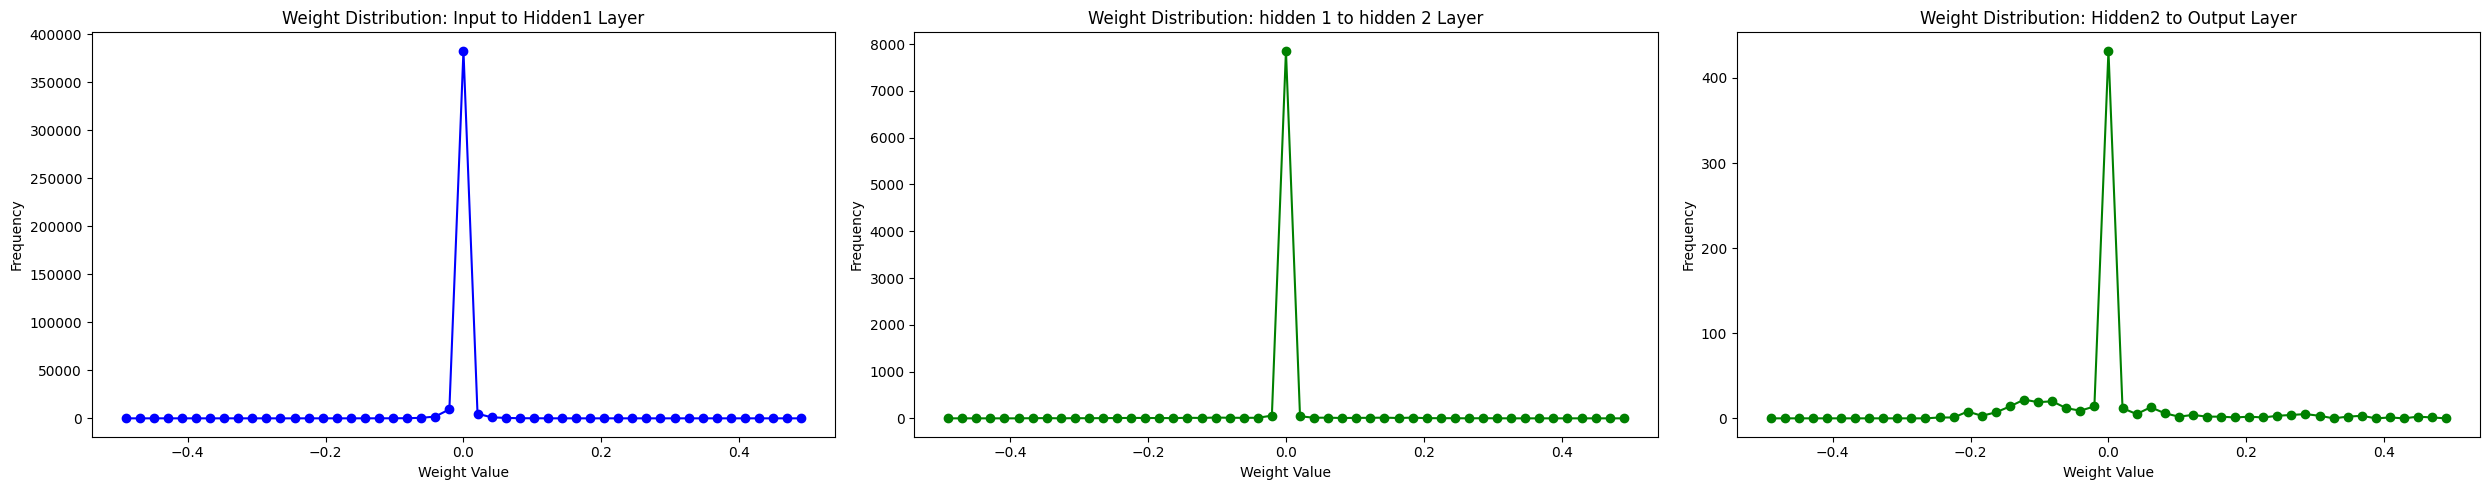

In [62]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: hidden 1 to hidden 2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [63]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 18948
Number of non-zero weights greater than 0.01 in layer 1: 334
Number of non-zero weights greater than 0.01 in layer 3: 209


In [64]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[0.8134357513199976, 0.038011713936481804, 0.0391998576987443, 0.49796127999681944, 0.001037685314637759, 0.8096099397781092, 0.008437150769044504, 0.0005195455315556551, 0.24536553503165387, 0.3797854465062827, 0.019864047149283266, 0.01231349774180607, 0.029735599926277067, 0.887924516493653, 1.0733156017812773, 0.15666048048628942, 0.39362853816163934, 0.4706019803956516, 0.07086016356670168, 0.04739902730870841, 0.678743320255354, 0.2215884784770149, 0.07701323279296926, 1.0453728002267357, 0.19527721647942906, 0.008920428994622469, 0.0517791176212962, 0.33848804980206004, 0.05281390481370467, 0.6846560202534198, 0.5736119405371921, 1.065599294525724, 0.33133290615456346, 0.5367502443195521, 0.5582305151858937, 0.9880222913087802, 0.5010292721286717, 0.0007780953018439987, 0.39486106545609617, 0.004157098525545327, 0.8454695416825031, 0.5088024259789459, 0.4243904307751403, 0.04587498676292789, 0.011406756230799469, 0.5782596692277953, 0.46605376794748776, 0.45490980831970723, 0.09

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_61136/2415192822.py:5: RuntimeWarning: invalid value encountered in scalar divide
  norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))


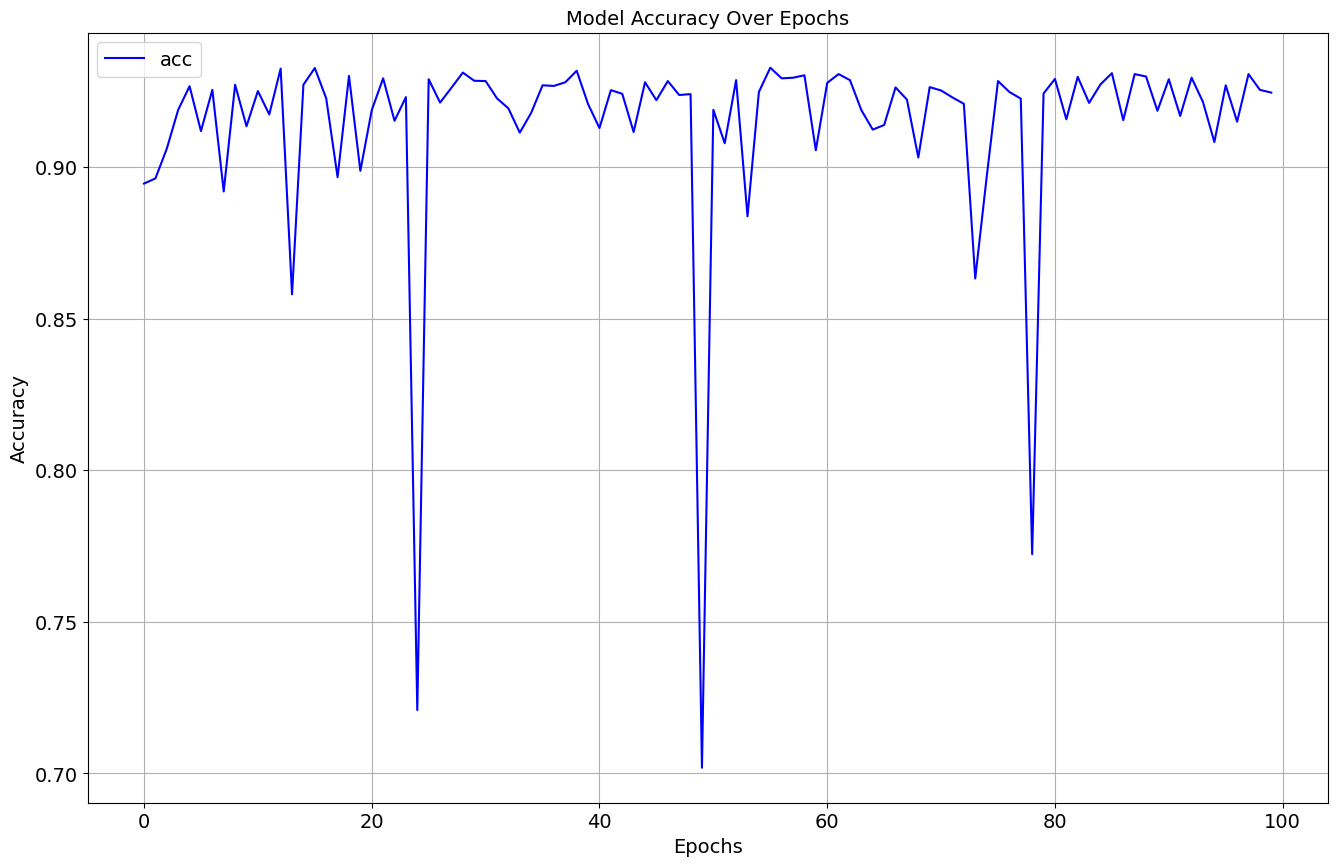

In [65]:
epochs_plot = list(range(100))

plt.figure(figsize=(16, 10))
plt.plot(epochs_plot, acc, linestyle='-', color='b', label='acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Over Epochs', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)

plt.legend(fontsize=14)

plt.show()

In [66]:
import pickle
with open('l2regularization1.pkl', 'wb') as f:
    pickle.dump(acc, f)